In [1]:
library(tidyverse)
library(stringr)
library(magrittr)
library(modelr)
library(broom)
library(purrr)

source("../R/utils.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract


Attaching package: 'broom'

The following object is masked from 'package:modelr':

    bootstrap



## Load the data

In [2]:
suppressMessages({

all_snps <- load_dataset("../tests/cadd/clean_data/ice_age.tsv",
                       "../tests/cadd/clean_data/sgdp.tsv",
                       "../tests/cadd/clean_data/archaics.tsv",
                       "../tests/cadd/clean_data/annotations.tsv",
                       filter_damage=TRUE,
                       metadata_path="../tests/cadd/10_24_2014_SGDP_metainformation_update.txt")

sgdp_info <-
  load_sgdp_info("../tests/cadd/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(!(pop == "Oceania" & Country != "PapuaNewGuinea")) %>%
  mutate(pop=ifelse(pop == "Oceania", "Papuan", pop))

emh_info <-
  read_delim("../tests/cadd/clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("Continenza", "Kostenki12", "Ostuni2",
                       "Pavlov1", "Vestonice15", "Vestonice43",
                       "Vestonice13", "Oase1", "Muierii2",
                       "AfontovaGora2"))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age,
         name=factor(name, levels=name),
         pop=as.factor(pop))
    
})

Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"Warning message in one_of(sgdp_info$name):
"Unknown variables: `S_Australian_1`, `S_Australian_5`"Warning message:
"673 parsing failures.
 row            col               expected  actual
2136 mapAbility35bp no trailing characters .5     
4607 mapAbility35bp no trailing characters .333333
5028 mapAbility35bp no trailing characters .5     
5379 mapAbility35bp no trailing characters .5     
5819 mapAbility35bp no trailing characters .5     
.... .............. ...................... .......
See problems(...) for more details.
"Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"

## Specify/plot conserved/neutral annotation bins

Warning message:
"Removed 140 rows containing non-finite values (stat_bin)."

Warning message:
"Removed 304 rows containing non-finite values (stat_bin)."

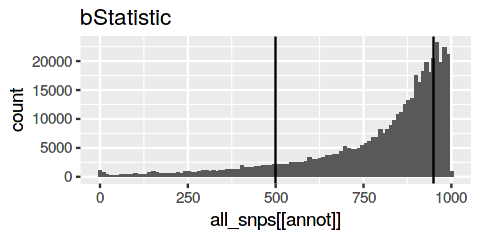

Warning message:
"Removed 261 rows containing non-finite values (stat_bin)."

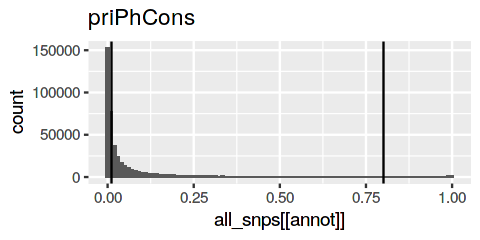

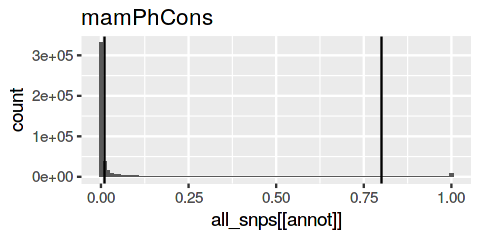

In [3]:
options(repr.plot.width=4, repr.plot.height=2)

plot_annot <- function(annot, low, high) {
  qplot(all_snps[[annot]], bins=100) +
      geom_vline(xintercept=c(low, high)) +
      ggtitle(annot)
}

b_low <- 500; b_high <- 950
priPhCons_low <- 0.01; priPhCons_high <- 0.8
mamPhCons_low <- 0.01; mamPhCons_high <- 0.8

plot_annot("bStatistic", b_low, b_high)
plot_annot("priPhCons", priPhCons_low, priPhCons_high)
plot_annot("mamPhCons", mamPhCons_low, mamPhCons_high)

## Divide SNPs into conserved/neutral bins based on different annotations

In [4]:
#
# Divide SNPs into two equal-sized bins (conserved and neutral)based
# on the given annotation.
#
bin_cons_neutral <- function(snps, stat,
                           low_cutoff, high_cutoff,
                           low_bin, high_bin, equalize=TRUE) {
  bins <- ifelse(snps[[stat]] <= low_cutoff, low_bin,
          ifelse(snps[[stat]] > high_cutoff, high_bin, NA))

  if (equalize) {
      # count the number of conserved and neutral elements
      counts <- table(bins)

      # get the bin with the highest number of snps
      max_bin <- names(counts)[which(counts == max(counts))]

      # make the counts of bin elements equal by removing a subset
      # of elements from the biggest of the two bins
      bins[sample(which(bins == max_bin), max(counts) - min(counts))] <- NA
  }

  factor(bins)
}

all_snps <-
  mutate(all_snps, # convert annotation types into numeric values for later binning
     genic=ifelse(AnnoType %in% c("CodingTranscript", "RegulatoryFeature"), 1,
           ifelse(AnnoType == "Intergenic", -1, NA)),
     coding=ifelse(AnnoType == "CodingTranscript", 1, ifelse(AnnoType == "Intergenic", -1, NA))
     ) %>% 
  mutate( # bin SNPs into conserved/neutral regions based on different annotations
     annot_bStatistic=bin_cons_neutral(., "bStatistic", b_low,  b_high, "conserved", "neutral"),
     annot_priPhCons= bin_cons_neutral(., "priPhCons",  priPhCons_low, priPhCons_high, "neutral",   "conserved"),
     annot_mamPhCons= bin_cons_neutral(., "mamPhCons",  mamPhCons_low, mamPhCons_high, "neutral",   "conserved"),
     annot_genic=     bin_cons_neutral(., "genic",        -1,   0, "neutral",   "conserved"),
     annot_coding=    bin_cons_neutral(., "coding",       -1,   0, "neutral",   "conserved"))

binned <- gather(all_snps, annot, region, starts_with("annot_")) %>%
  mutate(annot=str_replace(annot, "annot_", ""))

## Calculate Nea% in each conserved/neutral bin for all annotations

In [5]:
nea_cn <-
  samples_info %>%
  filter(pop != "Africa") %>%
  mutate(cons_vs_neutral=purrr::map(as.character(name), function(n) {
      select_(binned, "archaic_Altai", n, "annot", "region") %>%
          group_by(annot, region) %>%
          do(nea=calc_sharing_prop(., "archaic_Altai", n)) %>%
          unnest %>%
          filter(complete.cases(.))
  }))

## Ratios of Nea% in the most conserved vs most neutral regions

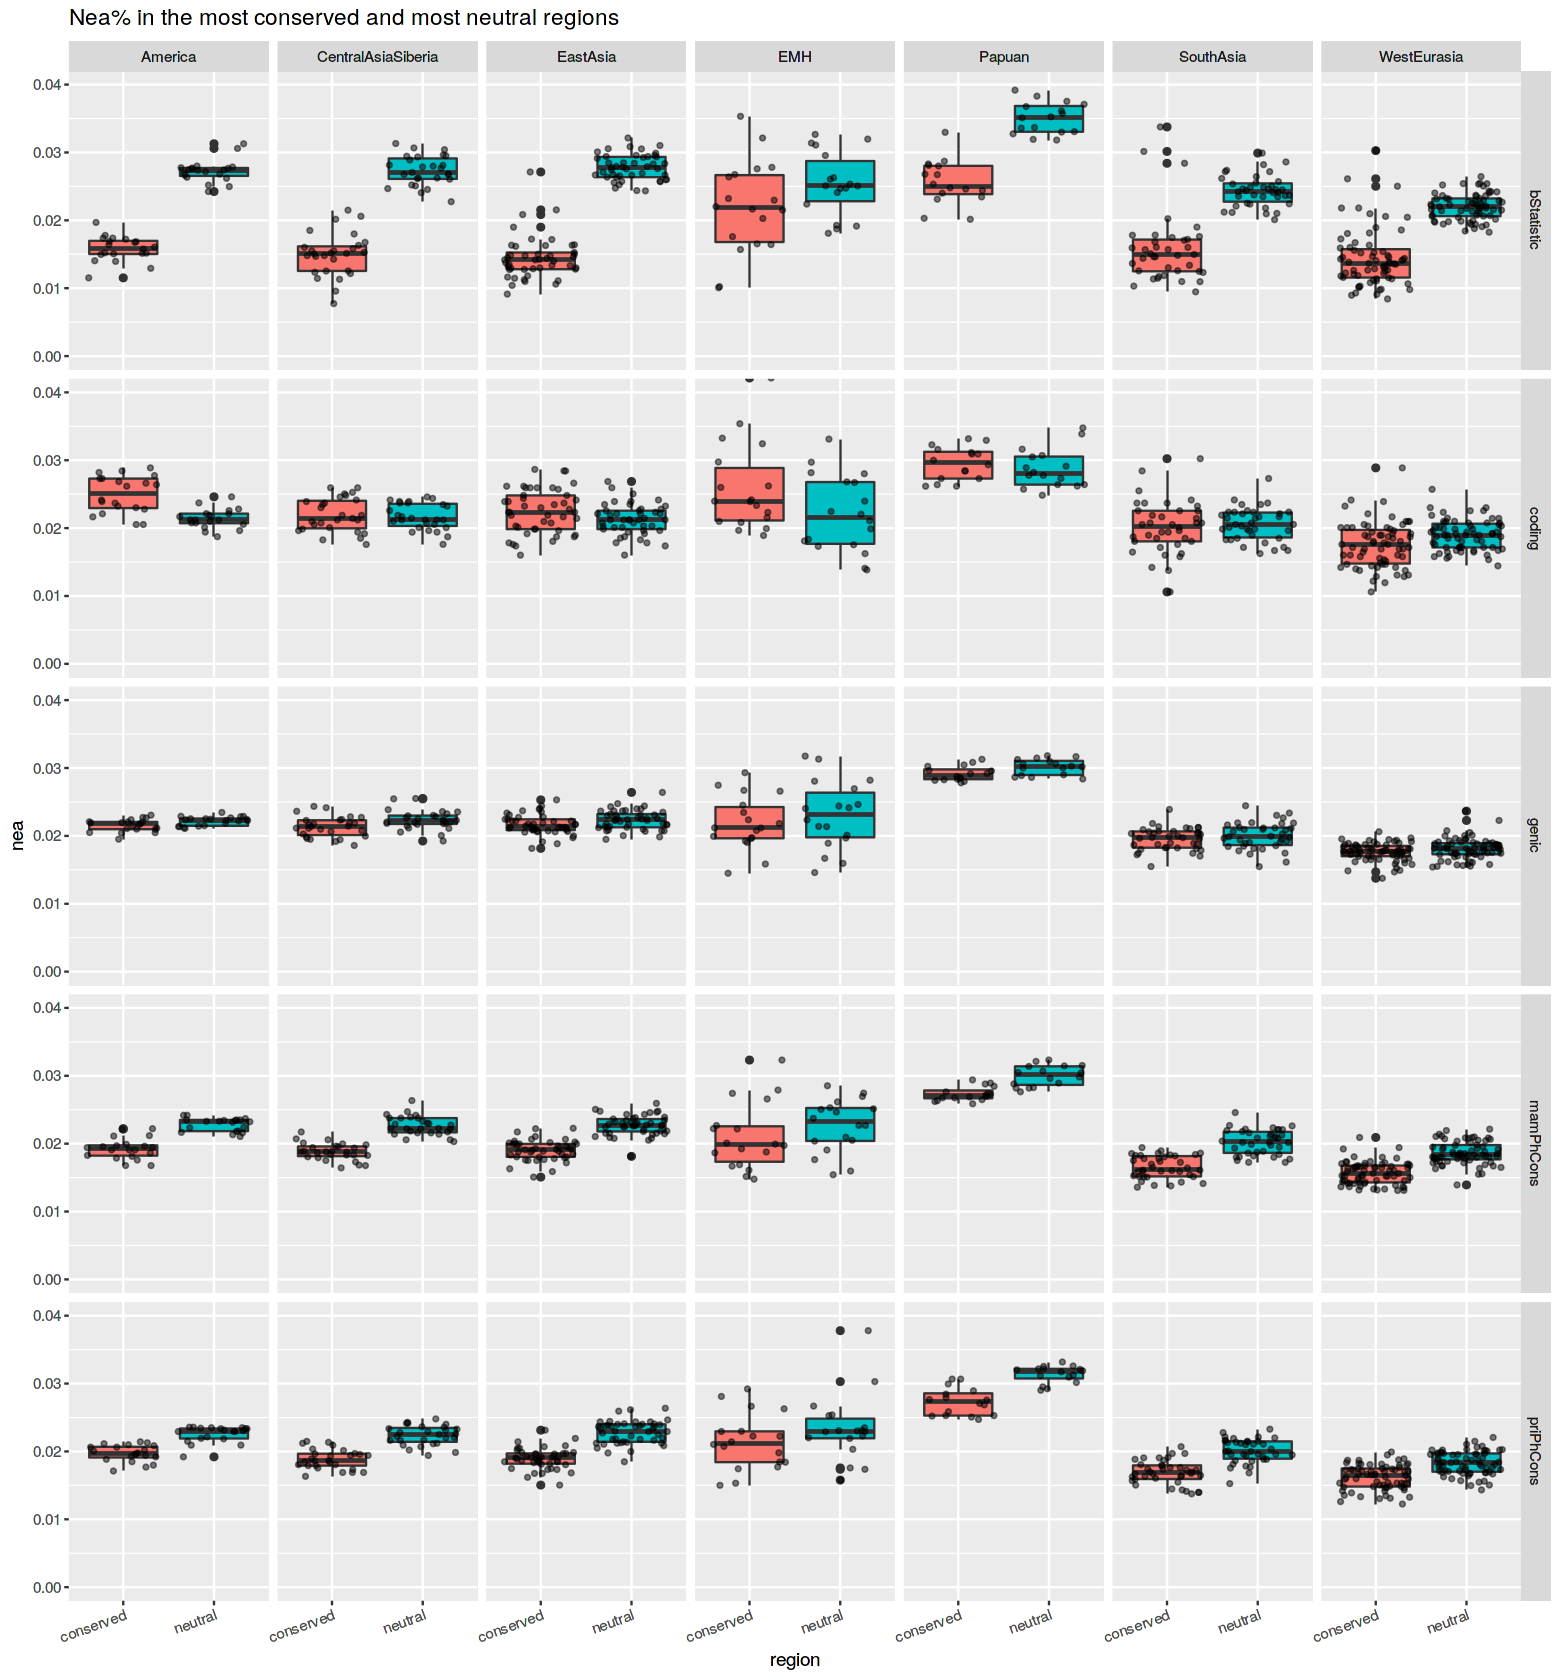

In [6]:
options(repr.plot.width=13, repr.plot.height=14)

unnest(nea_cn) %>%
  ggplot(aes(region, nea, fill=region)) +
  geom_boxplot() +
  facet_grid(annot ~ pop) +
  geom_jitter(alpha=1/2, size=1) +
  ggtitle("Nea% in the most conserved and most neutral regions") +
  coord_cartesian(ylim=c(0, 0.04)) +
  theme(axis.text.x=element_text(angle=20, hjust=1), legend.position="none")

## T-test of distribution of Nea% in conserved vs neutral regions

In [7]:
cons_vs_neutral_ttest <- function(df) { t.test(nea ~ region, data=df) }

## Nea% vs time in conserved/neutral regions

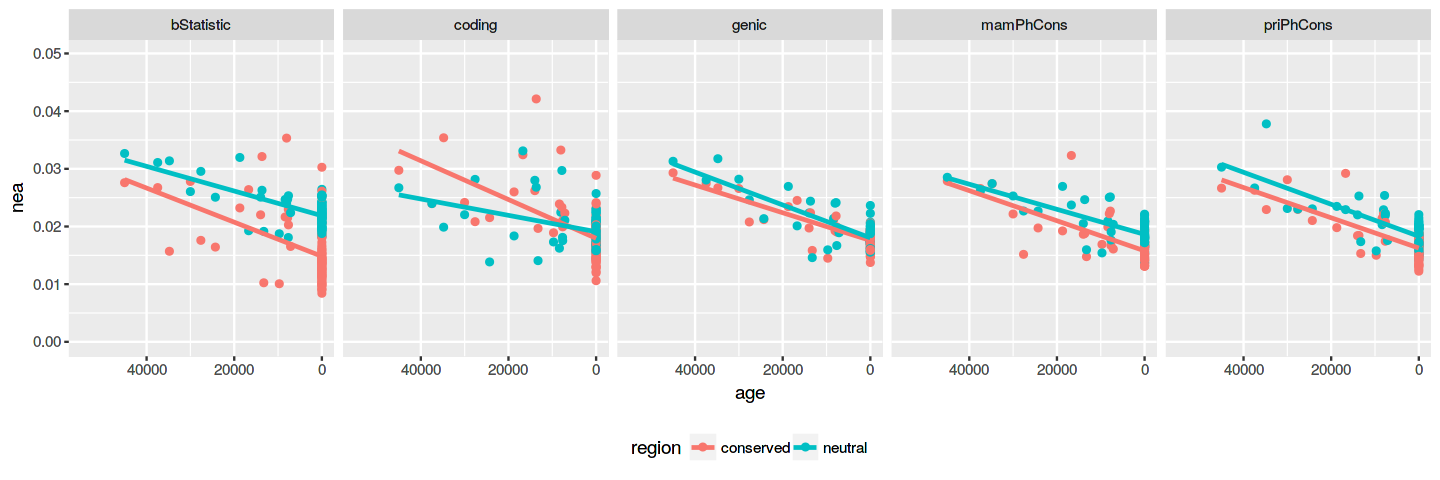

In [8]:
options(repr.plot.width=12, repr.plot.height=4)

nea_cn %>%
  filter(pop %in% c("EMH", "WestEurasia")) %>%
  unnest %>%
  ggplot(aes(age, nea, color=region)) +
  geom_point() +
  geom_smooth(method="lm", se=FALSE) +
  facet_grid(. ~ annot) +
  ylim(0, 0.05) + xlim(55000, 0) +
  theme(legend.position="bottom")

## Linear regression - B values

### Calculate Nea% per bin

Warning message:
"Removed 140 rows containing non-finite values (stat_bin)."

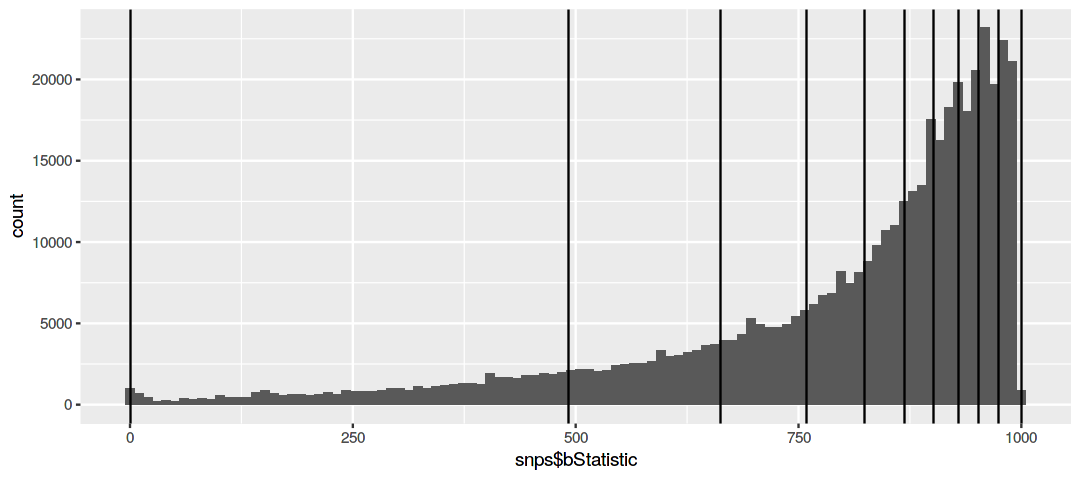

In [9]:
# B values
n_bins <- 10
cutoffs <- quantile(all_snps$bStatistic,
             prob=seq(0, 1, length.out=n_bins + 1),
             na.rm=TRUE)
snps <- mutate(all_snps,
             bin=findInterval(bStatistic, vec=cutoffs,
                              rightmost.closed=TRUE))

options(repr.plot.width=9, repr.plot.height=4)
qplot(snps$bStatistic, bins=100) + geom_vline(xintercept=cutoffs)

In [10]:
calc_nea_in_bins <- function(snps, n_bins, sample_name) {
    sapply(seq_len(n_bins), function(i) {
        calc_sharing_prop(filter(snps, bin == i), "archaic_Altai", sample_name)
    }) %>% as_tibble %>% mutate(bin=as.factor(seq_len(n_bins))) %>% rename(nea=value)
}

nea_bins <- samples_info %>%
    mutate(bins=purrr::map(as.character(name), function(n) { calc_nea_in_bins(snps, n_bins, n)}))

### Nea% in each bin aggregated by a population

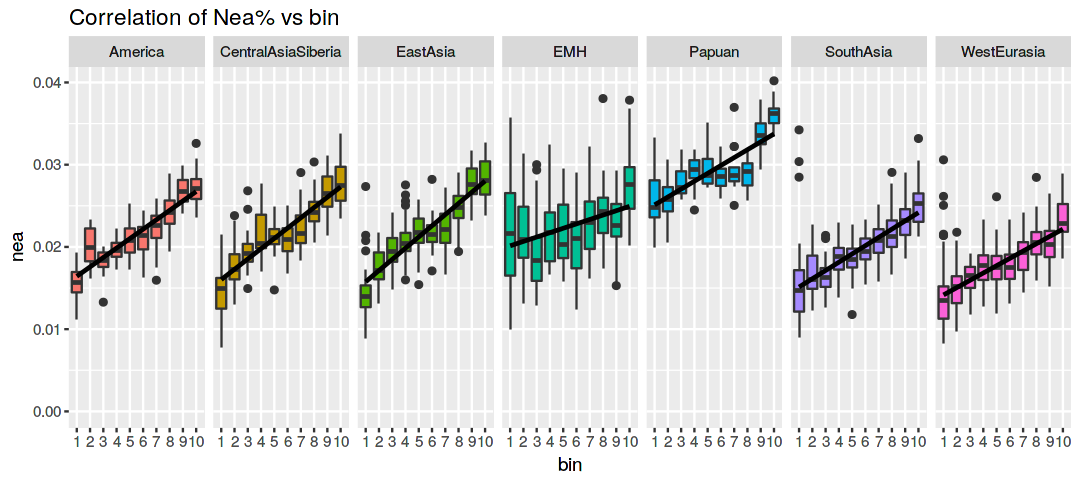

In [11]:
options(repr.plot.width=9, repr.plot.height=4)

# boxplots of Nea% per bin in each population
unnest(nea_bins, bins) %>% filter(pop != "Africa") %>%
  {
      ggplot(., aes(bin, nea, fill=pop, group=bin)) +
          geom_boxplot() +
          geom_smooth(method="lm", se=FALSE, color="black", aes(group=pop)) +
          coord_cartesian(ylim=c(0, 0.04)) +
          ggtitle(paste("Correlation of Nea% vs bin ")) +
          theme(legend.position="none") +
          facet_grid(. ~ pop)
  } %>% print

### Nea% in each bin aggregated by a population - per individual

### Nea% in each bin aggregated by a population - per individual

## Linear regression metrics

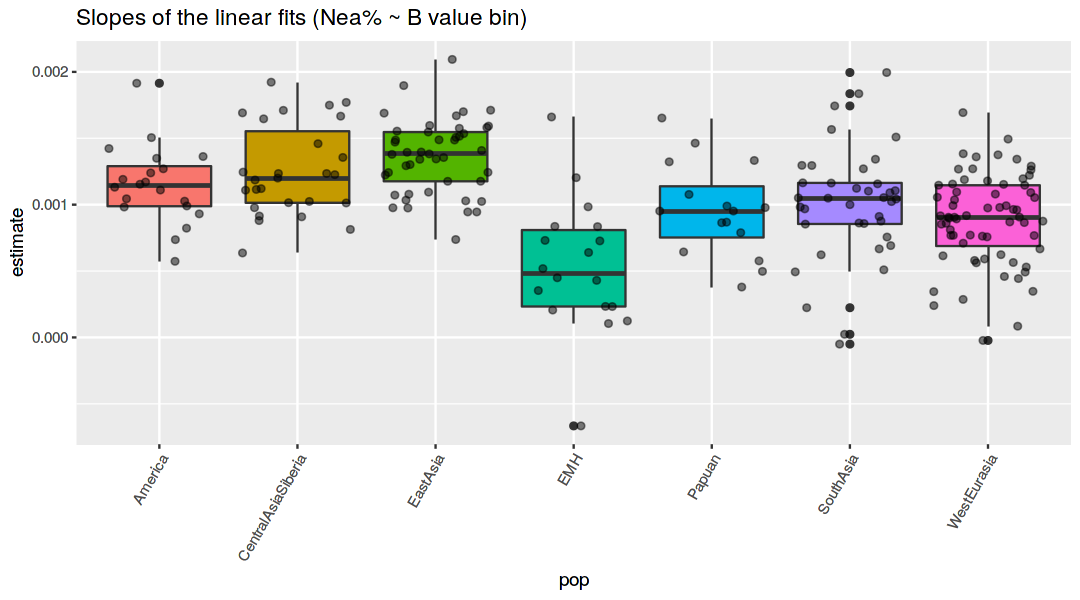

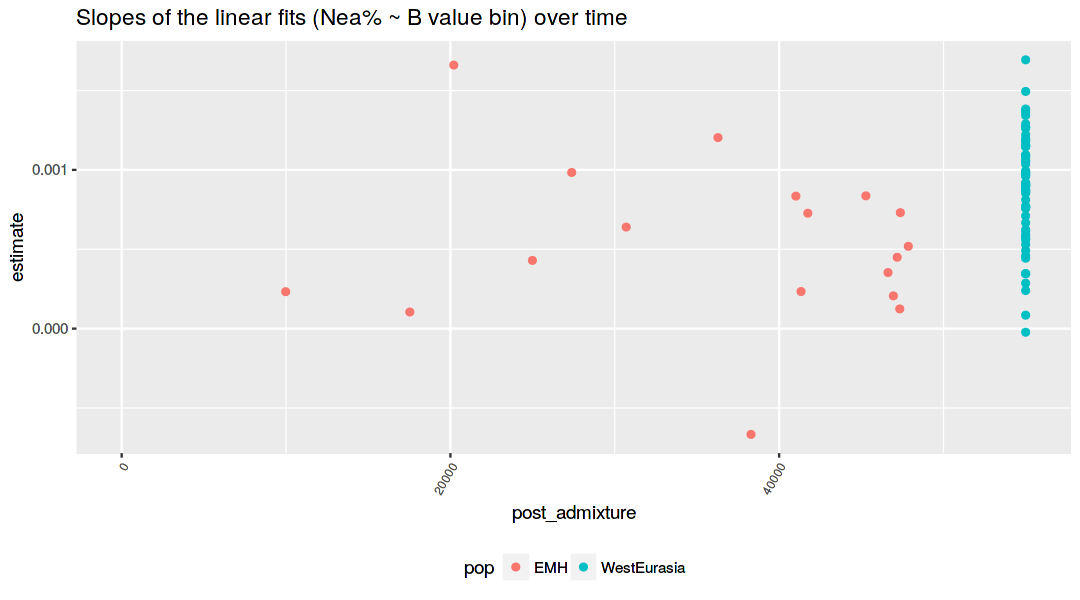

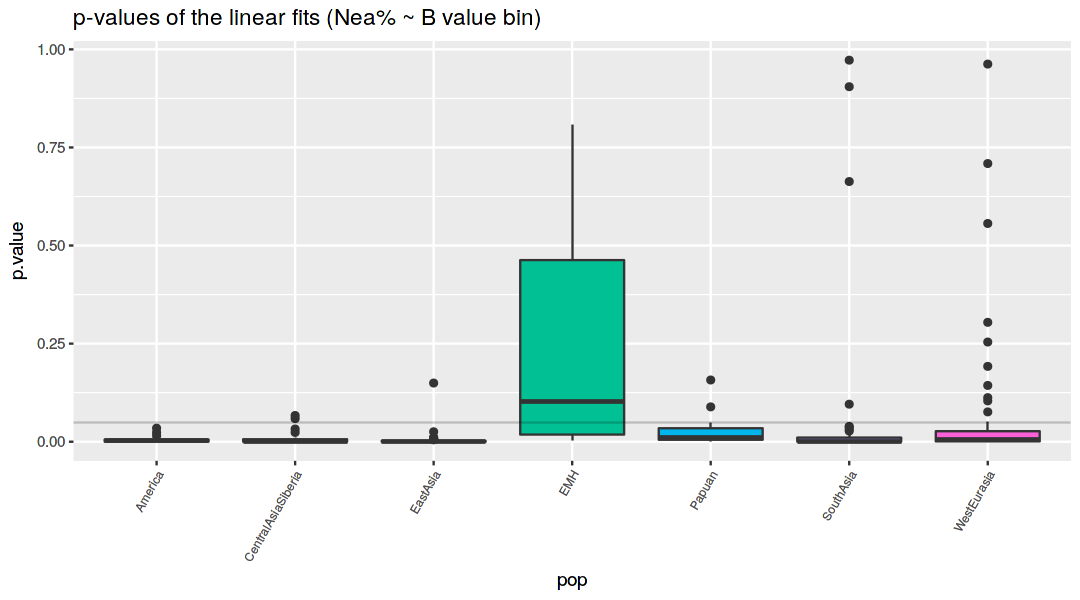

In [12]:
options(repr.plot.width=9, repr.plot.height=5)

nea_bin_lm <- function(df) {
  lm(nea ~ bin, data=mutate(df, bin=as.integer(bin)))
}

lm_per_sample <- nea_bins %>%
  unnest %>%
  filter(pop != "Africa") %>%
  group_by(name, pop, post_admixture) %>%
  nest %>%
  mutate(model=map(data, nea_bin_lm),
         glance=map(model, glance),
         tidy=map(model, tidy))

# plot the distribution of slopes in each pop
unnest(lm_per_sample, tidy) %>%
  filter(term == "bin") %>%
  ggplot(aes(pop, estimate, fill=pop)) +
  geom_boxplot() +
  geom_jitter(alpha=1/2) +
  ggtitle("Slopes of the linear fits (Nea% ~ B value bin)") +
  theme(axis.text.x=element_text(angle=60, hjust=1),
        legend.position="none")

# plot the slopes over time
unnest(lm_per_sample, tidy) %>%
  filter(term == "bin", pop == "EMH" | pop == "WestEurasia") %>%
  ggplot(aes(post_admixture, estimate, colour=pop)) +
  geom_point() +
  ggtitle("Slopes of the linear fits (Nea% ~ B value bin) over time") +
  theme(axis.text.x=element_text(angle=60, hjust=1, size=7),
        legend.position="bottom") +
  xlim(0, 55000)

# plot the p.value of each fit
unnest(lm_per_sample, glance, .drop=TRUE) %>%
  ggplot(aes(pop, p.value, fill=pop)) +
  geom_boxplot() +
  geom_hline(yintercept=0.05, alpha=1/5) +
  ggtitle("p-values of the linear fits (Nea% ~ B value bin)") +
  theme(axis.text.x=element_text(angle=60, hjust=1, size=7),
        legend.position="none")

In [13]:
library(maps)


Attaching package: 'maps'

The following object is masked from 'package:purrr':

    map



In [14]:
nea_est <- samples_info %>%
    mutate(nea=sapply(as.character(name), function(n) { calc_sharing_prop(all_snps, "archaic_Altai", n)}))

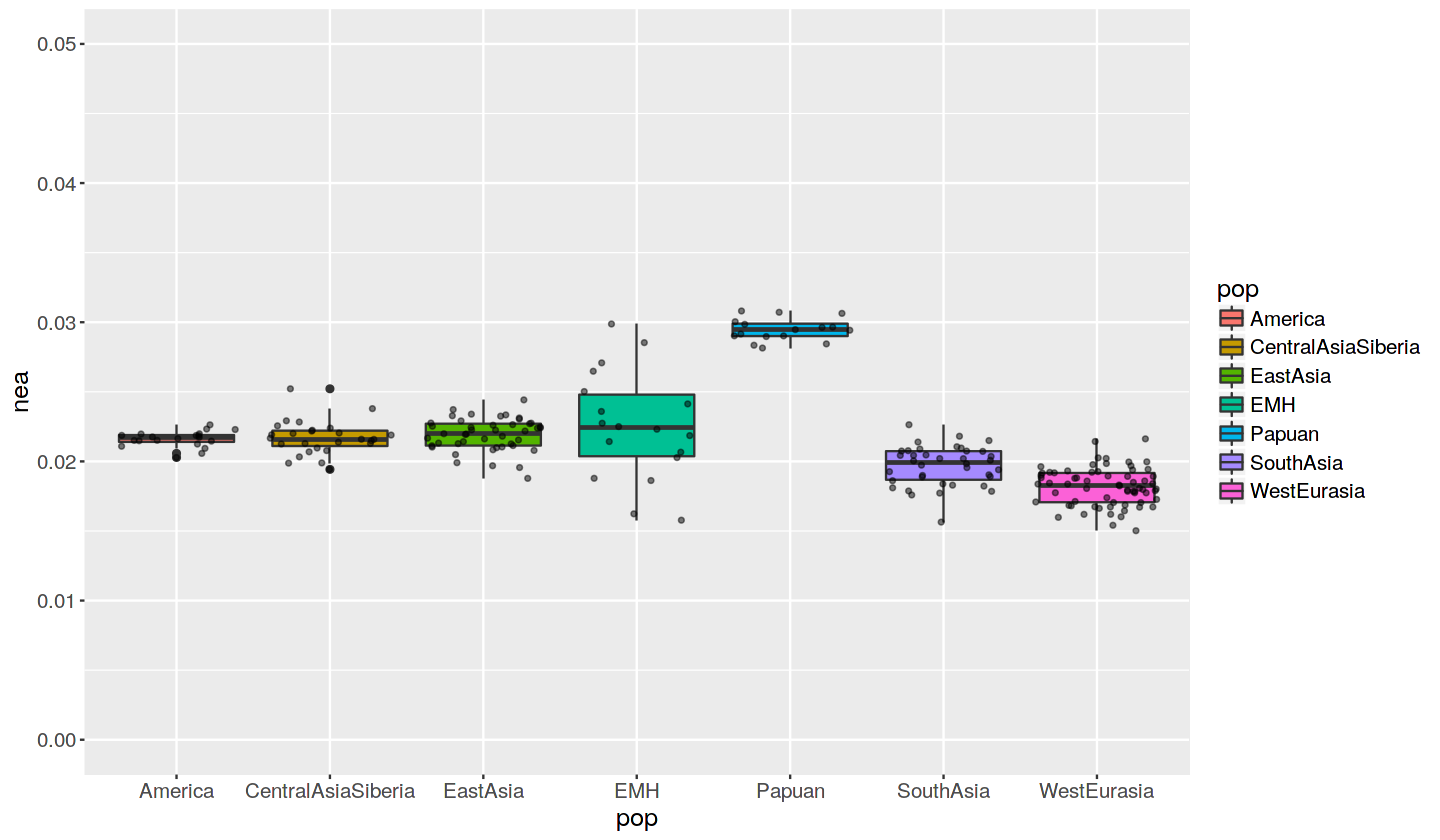

In [15]:
options(repr.plot.width=12, repr.plot.height=7)

filter(nea_est, pop != "Africa") %>%
ggplot() +
  geom_boxplot(aes(pop, nea, fill=pop)) +
  geom_jitter(aes(pop, nea), size=1, alpha=1/2) +
  coord_cartesian(ylim=c(0, 0.05)) +
  theme(text=element_text(size=15),
        legend.position="right")

In [16]:
head(nea_est)

name,age,pop,Country,Latitude,Longitude,post_admixture,nea
UstIshim,45020,EMH,NA,NA,NA,9980,0.02853459
Kostenki14,37470,EMH,NA,NA,NA,17530,0.02708133
GoyetQ116_1,34795,EMH,NA,NA,NA,20205,0.02987416
Vestonice16,30010,EMH,NA,NA,NA,24990,0.02647948
Ostuni1,27620,EMH,NA,NA,NA,27380,0.02249992
Malta1,24305,EMH,NA,NA,NA,30695,0.02231115


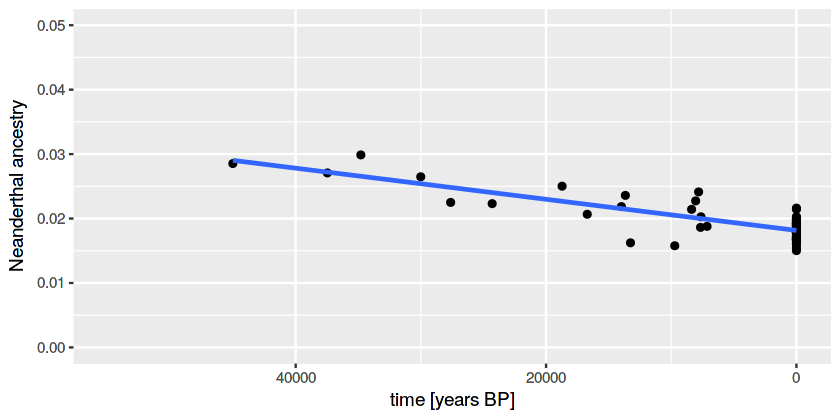

In [22]:
options(repr.plot.width=7, repr.plot.height=3.5)

filter(nea_est, pop %in% c("EMH", "WestEurasia")) %>%
    ggplot(aes(age, nea)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    ylim(0, 0.05) +
    scale_x_reverse(lim=c(55000, 0)) +
    labs(x="time [years BP]", y="Neanderthal ancestry")

Warning message:
"Removed 18 rows containing missing values (geom_point)."

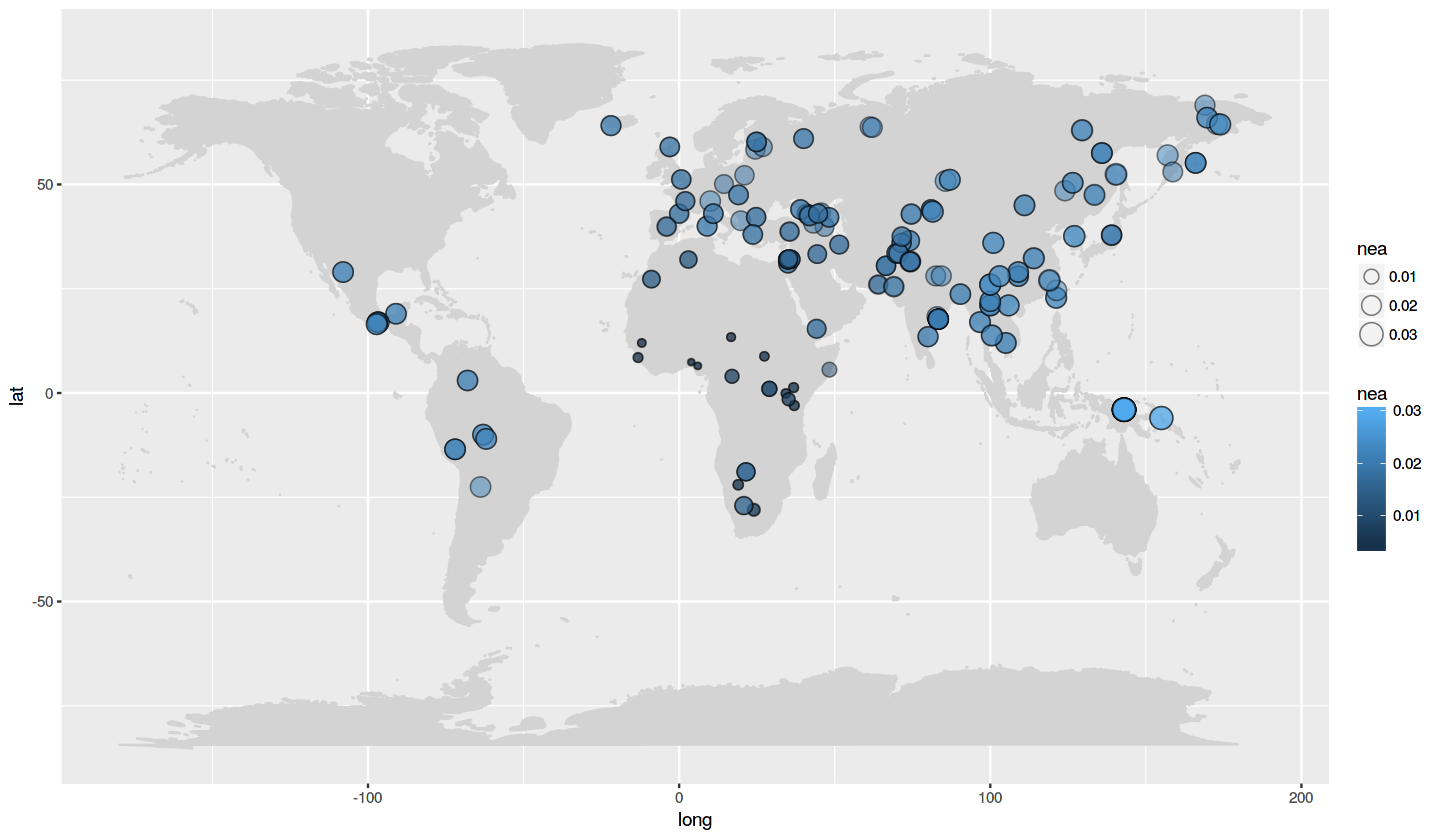

In [16]:
map_plot <-
  map_data("world") %>%
  ggplot() +
  geom_polygon(aes(x=long, y=lat, group=group), 
               colour="light gray", fill="light gray")

map_plot +
  geom_point(data=nea_est, 
             aes(Longitude, Latitude, fill=nea, size=nea), pch=21, alpha=1/2)